In [24]:
!uv init && uv venv && source .venv/bin/activate && uv add matplotlib numpy soundfile scipy noisereduce

Initialized project `jupyter`
Using CPython 3.12.10
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Resolved 20 packages in 67ms                                         
Installed 18 packages in 36ms                                    
 + cffi==1.17.1
 + contourpy==1.3.2
 + cycler==0.12.1
 + fonttools==4.57.0
 + joblib==1.5.0
 + kiwisolver==1.4.8
 + matplotlib==3.10.3
 + noisereduce==3.0.3
 + numpy==2.2.5
 + packaging==25.0
 + pillow==11.2.1
 + pycparser==2.22
 + pyparsing==3.2.3
 + python-dateutil==2.9.0.post0
 + scipy==1.15.3
 + six==1.17.0
 + soundfile==0.13.1
 + tqdm==4.67.1


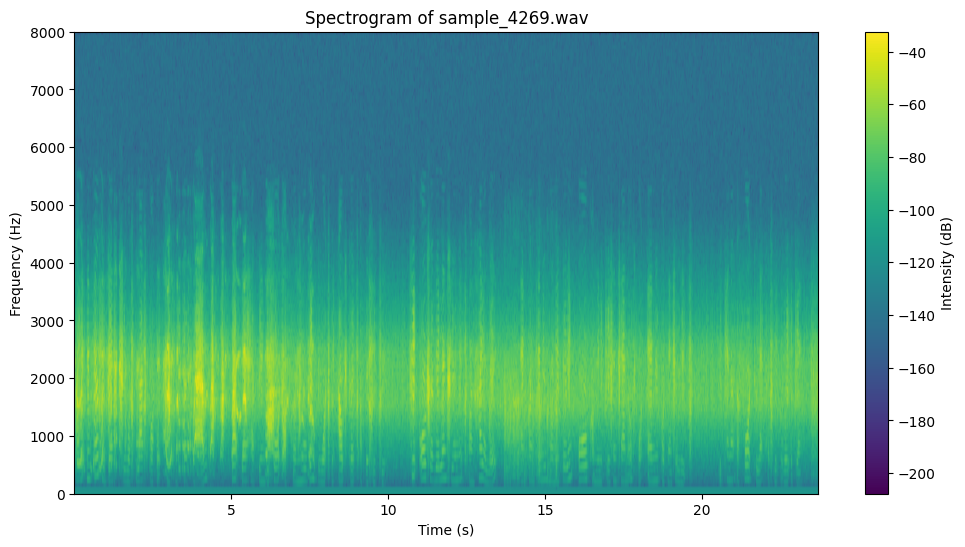

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

def print_spectrogram(file_path):
    """
    Generates and displays the spectrogram of a WAV file.

    Args:
        file_path (str): Path to the WAV file.
    """
    try:
        audio_data, sample_rate = sf.read(file_path)
    except sf.SoundFileError:
        print(f"Error: Could not read file at {file_path}. Ensure it is a valid WAV file.")
        return

    plt.figure(figsize=(12, 6))
    plt.specgram(audio_data, Fs=sample_rate, cmap='viridis')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Spectrogram of {file_path}')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

file_path = 'sample_4269.wav'  # Replace with your WAV file path
print_spectrogram(file_path)

In [6]:
!source .venv/bin/activate && uv sync && uv run pip install noisereduce

Resolved 20 packages in 0.83ms
Audited 18 packages in 0.01ms


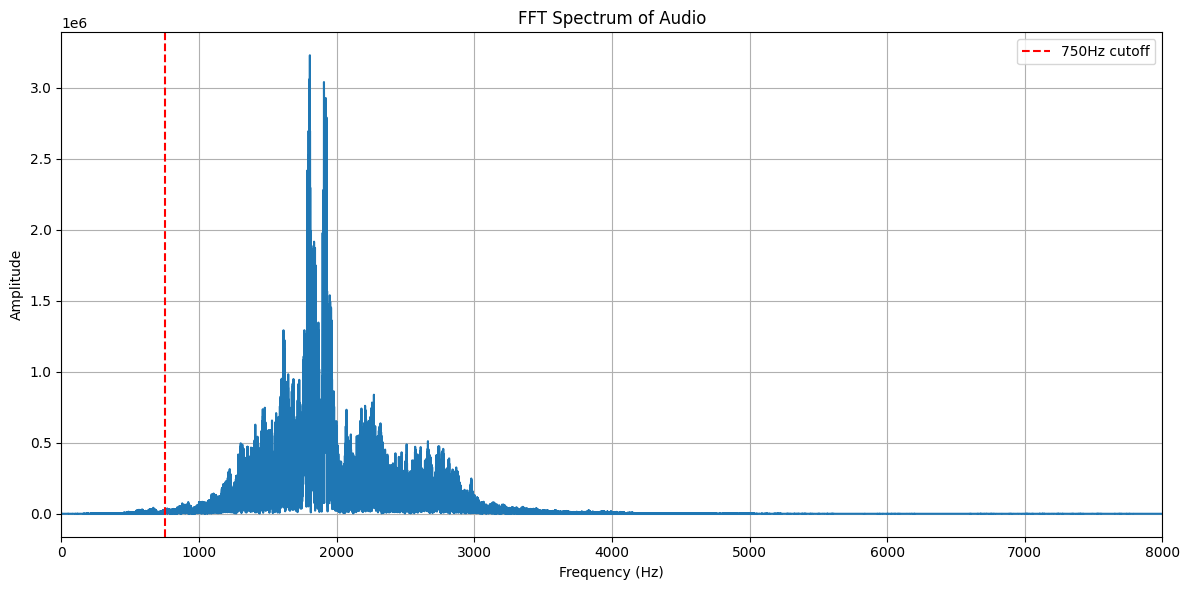

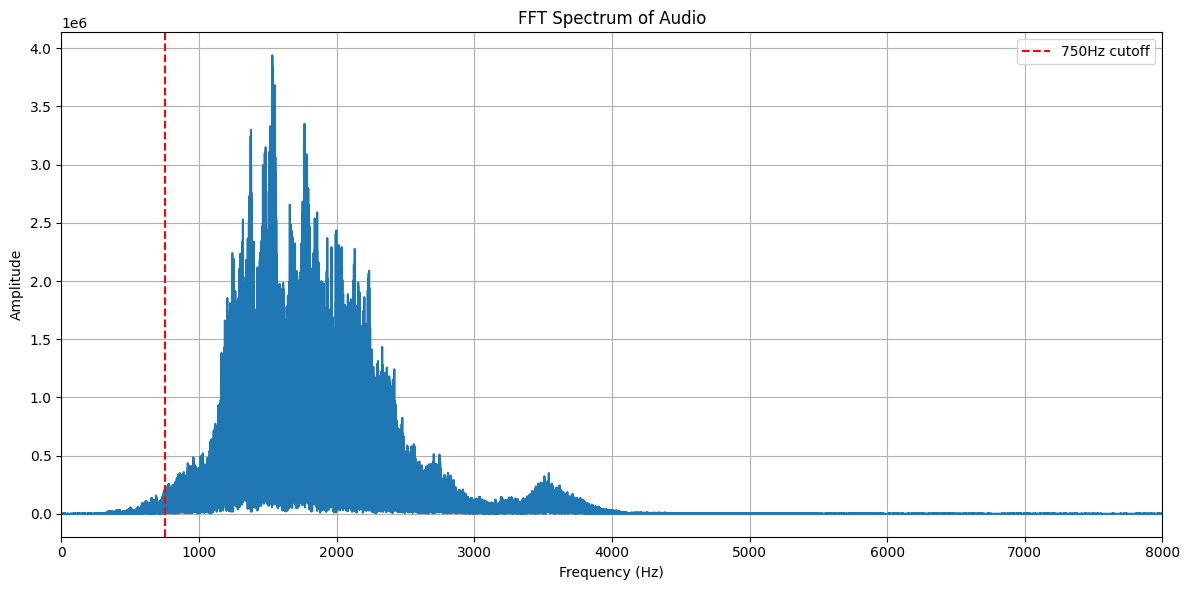

In [9]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
import noisereduce as nr

# --- Load audio file ---
rate, data = wav.read("sample_3890.wav")
reduced_noise = nr.reduce_noise(y=data, sr=rate)

# --- Convert stereo to mono if needed ---
if data.ndim == 2:
    data = data.mean(axis=1)

# --- Perform FFT ---
n = len(reduced_noise)
fft_out = fft(reduced_noise)
fft_mag = np.abs(fft_out[:n // 2])  # Take positive half
freqs = np.fft.fftfreq(n, d=1/rate)[:n // 2]  # Frequency axis

# --- Plot frequency spectrum ---
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_mag)
plt.title("FFT Spectrum of Audio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, rate / 2)
plt.axvline(750, color='r', linestyle='--', label='750Hz cutoff')
plt.legend()
plt.tight_layout()
plt.show()


# --- Load audio file ---
rate, data = wav.read("sample_4490.wav")
reduced_noise = nr.reduce_noise(y=data, sr=rate)

# --- Convert stereo to mono if needed ---
if data.ndim == 2:
    data = data.mean(axis=1)

# --- Perform FFT ---
n = len(reduced_noise)
fft_out = fft(reduced_noise)
fft_mag = np.abs(fft_out[:n // 2])  # Take positive half
freqs = np.fft.fftfreq(n, d=1/rate)[:n // 2]  # Frequency axis

# --- Plot frequency spectrum ---
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_mag)
plt.title("FFT Spectrum of Audio")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.xlim(0, rate / 2)
plt.axvline(750, color='r', linestyle='--', label='750Hz cutoff')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
'''
This is lowpass then spectral gating
'''
from scipy.io import wavfile
import noisereduce as nr
from scipy.signal import firwin, filtfilt
import numpy as np

# --- Parameters ---
cutoff_freq = 750  # Hz
numtaps = 4096      # High number of taps = sharper cutoff

# --- Filter Function ---
def fir_lowpass_filter(data, cutoff_hz, fs, numtaps=4096):
    nyq = 0.5 * fs
    fir_coeff = firwin(numtaps, cutoff_hz / nyq, window='hamming')
    return filtfilt(fir_coeff, [1.0], data)

# --- Load WAV ---
rate, data = wavfile.read(file_path)
data = data.astype(np.float32)

# --- Handle Stereo ---
if len(data.shape) == 2:
    filtered_channels = []
    for ch in range(data.shape[1]):
        filtered = fir_lowpass_filter(data[:, ch], cutoff_freq, rate)
        filtered_channels.append(filtered)
    filtered_data = np.stack(filtered_channels, axis=1)
else:
    filtered_data = fir_lowpass_filter(data, cutoff_freq, rate)

# --- Apply Noise Reduction (Optional) ---
reduced_noise = nr.reduce_noise(y=filtered_data, sr=rate)

# --- Normalize and Convert Back ---
norm = np.max(np.abs(reduced_noise))
normalized = (reduced_noise / norm) * 32767
final_output = normalized.astype(np.int16)

# --- Write WAV ---
wavfile.write("filtered_output_lp_sg.wav", rate, final_output)


In [32]:
'''
This is spectral gating then lowpass
'''
from scipy.io import wavfile
import noisereduce as nr
from scipy.signal import firwin, filtfilt
import numpy as np

# --- Parameters ---
cutoff_freq = 750  # Hz
numtaps = 4096      # High number of taps = sharper cutoff

# --- Filter Function ---
def fir_lowpass_filter(data, cutoff_hz, fs, numtaps=4096):
    nyq = 0.5 * fs
    fir_coeff = firwin(numtaps, cutoff_hz / nyq, window='hamming')
    return filtfilt(fir_coeff, [1.0], data)

# --- Load WAV ---
rate, data = wavfile.read(file_path)
data = data.astype(np.float32)

# --- Handle Stereo and Apply Noise Reduction First ---
if len(data.shape) == 2:
    denoised_channels = []
    for ch in range(data.shape[1]):
        denoised = nr.reduce_noise(y=data[:, ch], sr=rate)
        filtered = fir_lowpass_filter(denoised, cutoff_freq, rate)
        denoised_channels.append(filtered)
    processed_data = np.stack(denoised_channels, axis=1)
else:
    denoised = nr.reduce_noise(y=data, sr=rate)
    processed_data = fir_lowpass_filter(denoised, cutoff_freq, rate)

# --- Amplify and Clip ---
# Amplify
gain = 1.25
amplified = processed_data * gain

# Normalize safely to prevent clipping
peak = np.max(np.abs(amplified))
if peak > 1.0:
    amplified = amplified / peak

# Convert to int16
final_output = (amplified * 32767).astype(np.int16)

wavfile.write("filtered_output_sg_lp.wav", rate, final_output)


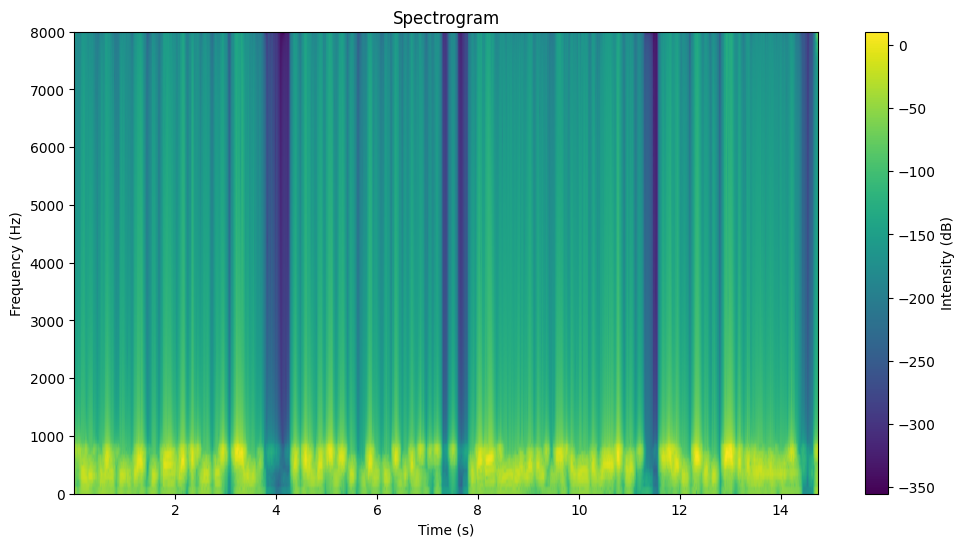

In [16]:
def print_spectrogram_from_array(audio_data, sample_rate, title="Spectrogram"):
    plt.figure(figsize=(12, 6))
    plt.specgram(np.where(audio_data == 0, 1e-10, audio_data), Fs=sample_rate, cmap='viridis')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.colorbar(label='Intensity (dB)')
    plt.show()
print_spectrogram_from_array(reduced_noise, rate)

In [31]:
!rm -rf .venv && rm pyproject.toml && rm uv.lock